In [1]:
import numpy as np
from astropy.io import fits
import glob
import matplotlib.pyplot as plt  
from matplotlib.animation import FuncAnimation, PillowWriter  

from astropy.visualization import SinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SinhStretch())

In [29]:
imlist = glob.glob('data/*.fits')
imlist

['data\\11Apr13_Ha.fits',
 'data\\15May15_Ha.fits',
 'data\\16May15_Ha.fits',
 'data\\18May15_Ha.fits',
 'data\\27Apr18_Ha.fits',
 'data\\8Apr14_long_Ha.fits']

In [30]:
imlist = imlist[0:1]+imlist[5:]+imlist[1:2]+imlist[3:5]
imcube = np.zeros((len(imlist),451,451))
i = 0
for im in imlist:
    imdata = fits.getdata(im)
    imdata[np.isnan(imdata)] = np.nanmedian(imdata)
    imcube[i] = imdata
    i += 1

In [33]:
lims = [[-22, 30],
        [-27, 29],
        [-60, 45],
        #[-9, 12],
        [-615, 850],
        [-55, 80]]

date = []
for im in imlist:
    d = im.replace('data\\', '')
    d = d.replace('_Ha.fits', '')
    date.append(d)
date

['11Apr13', '8Apr14_long', '15May15', '18May15', '27Apr18']

<ipython-input-34-ea52125494bc>:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.imshow(imcube[i], origin='lower', norm=norm, vmin=lims[i][0], vmax=lims[i][1], cmap='inferno')


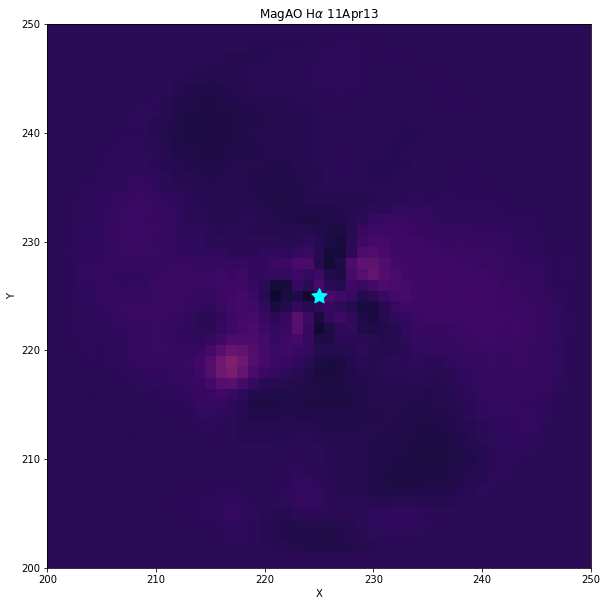

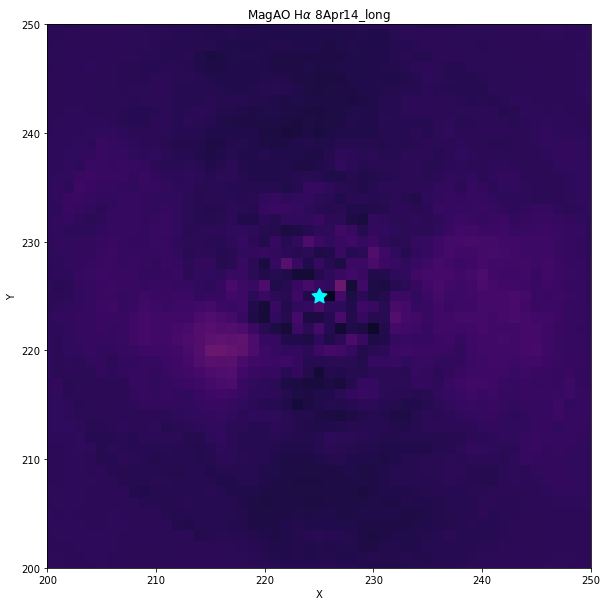

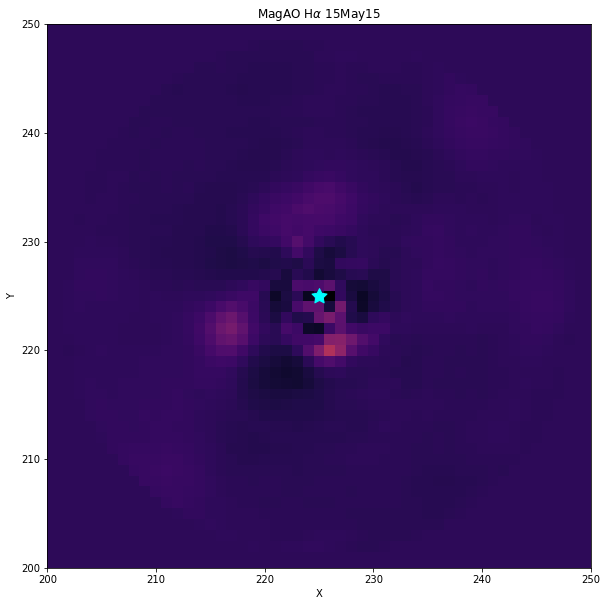

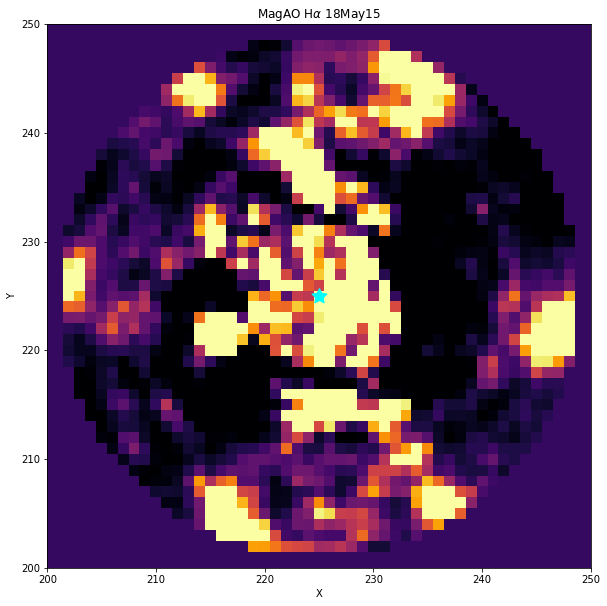

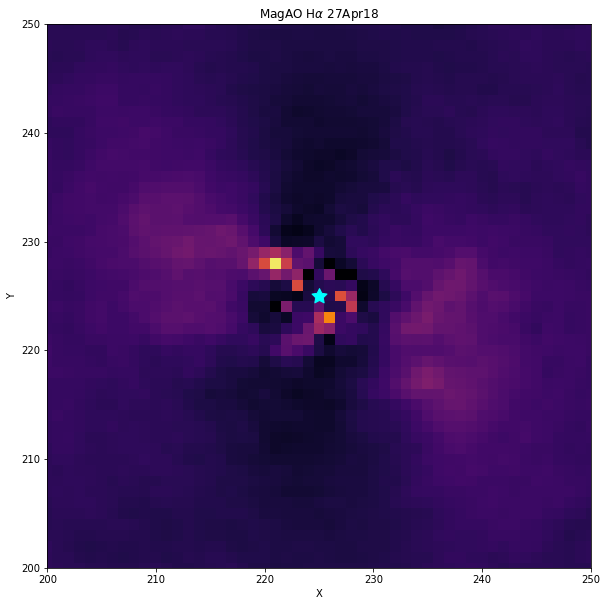

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

def plot_for_offset(i):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(imcube[i], origin='lower', norm=norm, vmin=lims[i][0], vmax=lims[i][1], cmap='inferno')
    ax.scatter([225], [225], c='cyan', s=250, marker=(5, 1))
    
    ax.plot()
    ax.set(xlabel='X', ylabel='Y',
           title=r'MagAO H$\alpha$ {}'.format(date[i]))

    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    ax.set_xlim(200, 250)
    ax.set_ylim(200, 250)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./orbit.gif', [plot_for_offset(i) for i in range(len(imlist))], fps=1)